Scope:

This project aims to look into ways of characterizing a behavioural process with tools and parameters used in information theory.  
This can give more insight into the nature of the process and can in turn be used to create models trying to explain behaviour following similar processes.

Example of a fair coin:

To have an easy example for how to calculate and estimate the information theoretic measures, which we want to apply to a Markov process later on, we can try them out on a fair coin flip.

For a fair coin, the total entropy of a measurement of the length L equals $$H(L) =  \frac{2^L}{2^L} \log_2{(\frac{1}{2^L})} = L$$, coming from the fact that there are allways $2^L$ different combinations one can achieve from observing a coin for $L$ consecutive flips.
This implies that the entropy rate is $$h_{\mu} = \lim_{L \to \infty} \frac{H(L)}{L} = 1$$ (also see https://wiki.santafe.edu/images/1/1d/ComplexityLecture1D.pdf, slide 8).  
With this, the excess entropy can be evaluated to $$E = \lim_{L \to \infty} (H(L) - h_{\mu}L) = \lim_{L \to \infty} (L-L) = 0$$ and finally the total transient information $$\sum_{L=0}^{\infty} E + h_{\mu}L - H(L) = \sum_{L=0}^{\infty} 0 = 0$$.  
This means that in the case of a fair coin, there is no transient information for consecutive coin flips, an agent observing the system would instantly be synchronized and able to estimate the randomness of the system correctly.
It is important to note, that this assumes that the agent is able to estimate the entropy of the combinations perfectly.

But what about estimating the entropy of the coin flip itself, just by observing multiple consecutive ones?
One can show, that the entropy estimated by using the amounts of 1s and 0s in sequences of length L is equal to
$$
H(L) = - \sum_{k=1}^{L-1} {L \choose k} \frac{1}{2^L} [\frac{k}{L} \log_2{(\frac{k}{L})} + (1-\frac{k}{L}) \log_2{(1-\frac{k}{L})}],
$$
using the binomial coefficient $ {L \choose k} = \frac{L!}{k!(L-k)!} $.

It can be shown that $|[...]| < 1$, which implies that the upper convergence bound for $H(L)$ is 1 (binomial theorem).
With this, the entropy rate in this case is 0. 
This means that the excess entropy is equal to the ideal entropy of the coin flip, so $E = 1$.
The total transient information would then be $\sum_{L=0}^{\infty} 1 - H(L)$, which does not converge (I think, H should converge to 1, can only show upper bound = 1).
This would make sense, since an agent observing only a finite amount of coin flips at a given time will estimate the entropy correctly only in the limit of infinity.
One will see that the estimation converges towards viable estimations of 1 quite quickly, if one is content with estimating to a certain threshold.

total transient information: 4.960785416176211


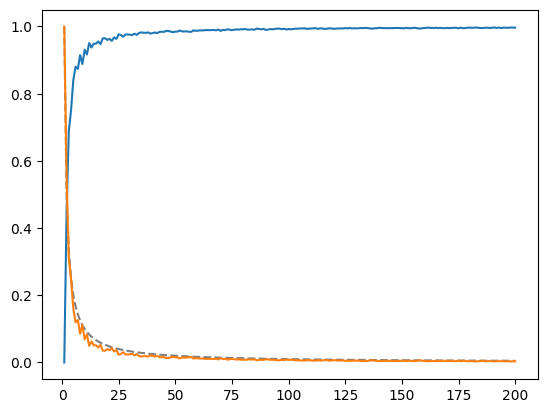

In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

def usfreq(s): # calculate frequency of each unique sample value in order of appearance
    ucount = np.unique(s, return_counts = True)[1]
    return(ucount)


## testing average entropy convergence  with sample length for fair coin flip
L = 200 # max length of measurements
N = 100 # number of repetitions to average over
H = np.zeros(L)
for l in range(1, L):
    for n in range(N):
        s = np.random.binomial(1, 0.5, l+1)
        H[l] += 1/N * sp.stats.entropy(usfreq(s), base = 2)

plt.plot(np.arange(1, L+1, 1), H)


# excess entropy
t_ent = 1 # true entropy of fair coin flip
ex_ent = t_ent + 0 # no entropy rate => excess entropy = true entropy
T = 1 - H
plt.plot(np.arange(1, L+1, 1), 1/np.arange(1, L+1, 1), color = "gray", ls = "--")
plt.plot(np.arange(1, L+1, 1), T)
print("total transient information:", np.sum(T))


Observing the delayed action MDP

The problem, which will be looked at in more detail, is a so-called "delayed action" experiment. One can picture an agent in a box, with a light switch, the light itself and a hatch through which a reward is given.
This setup can be described with the following Markov Decision Process (MDP), where $P_{ai}, P_{wi}, i = {0, 1, 2}$ denote the agent's policy to act or wait in a given state and $p_X$ is the base probability for the light to turn on when currently switched off.

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pygraphviz
import os
import pickle
#from network_viz_functions import create_lower_diGraph, create_upper_diGraph
#os.environ["R_HOME"] = "C:\\Users\\alexa\\anaconda3\\envs\\PS\\Lib\\R"
#import rpy2.robjects as ro
#%load_ext rpy2.ipython

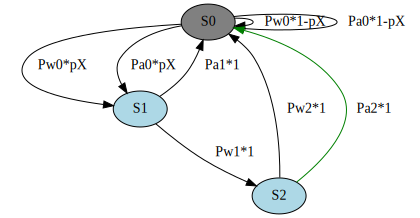

In [93]:
da_graph = nx.MultiDiGraph()
da_graph.add_nodes_from([("S0", {"fillcolor": "grey", "subset":0}), ("S1", {"fillcolor": "lightblue", "subset":0}), ("S2", {"fillcolor": "lightblue", "subset":0})])
edges = [("S0", "S1", "Pw0", {"p":"pX"}),
         ("S0", "S0", "Pw0", {"p":"1-pX"}),
         ("S0", "S1", "Pa0", {"p":"pX"}),
         ("S0", "S0", "Pa0", {"p":"1-pX"}),
         ("S1", "S2", "Pw1", {"p":1}),
         ("S1", "S0", "Pa1", {"p":1}),
         ("S2", "S0", "Pw2", {"p":1}),
         ("S2", "S0", "Pa2", {"p":1, "color": "green"})]
da_graph.add_edges_from(edges)
labels = {(edge[0], edge[1], edge[2]):str(edge[2] + "*" + str(edge[3]["p"]) + "   ") for edge in da_graph.edges(data = True, keys = True)}
nx.set_edge_attributes(da_graph, labels, "label")

D = nx.drawing.nx_agraph.to_agraph(da_graph)
D.node_attr.update(style = "filled")
D.layout('dot')

D

The agent now moves through the states according to its policy, but what is the result of this?
The state transition matrix for this MDP has the following form:
$$
\begin{matrix} S_0 & S_1 & S_2 \end{matrix} \\
\begin{matrix} S_0 \\  S_1  \\  S_2 \end{matrix}
\begin{bmatrix} 1 - p_X & p_X & 0 \\ \pi_{a1} & 0 & 1 - \pi_{a1} \\ 1 & 0 & 0 \end{bmatrix} = P.
$$
The n-step transition probability, so ending up in a specific state given the initial state, can be calculated with $P^n$, where after $P_{ij}^n$ denotes the probability to end up in state $j$ after $n$ steps, given that the initial state was $i$.
Naturally, the question of probabilities for the states in the limit of infinity arises, which is called the limiting state probability of a Markov Process.
For a positive recurrent MP, which our example is, the limiting state probability matrix $C$ can be calculated using the z-transform of the transition matrix, using
$$
G(z) = [I-Pz]^{-1} = \frac{1}{1-z}C + T(z),
$$
With $G(z)$ being the z-transform of $P^n$. The resulting matrix $C$ is constant (independent of z), with all rows being identical.

In [47]:
import sympy as sp

x = sp.Symbol("p_X")
a1 = sp.Symbol("\pi_{a1}")
z = sp.Symbol("z")

P = sp.Matrix([[1-x, x, 0],[a1, 0, 1-a1], [1, 0, 0]])

A = sp.eye(3) - P*z
print("G(z)=")
sp.apart(A.inv(), z)


G(z)=


Matrix([
[                                -p_X*(\pi_{a1}*z + \pi_{a1} - z - 2)/((\pi_{a1}*p_X - 2*p_X - 1)*(\pi_{a1}*p_X*z**2 - p_X*z**2 - p_X*z - 1)) + 1/((z - 1)*(\pi_{a1}*p_X - 2*p_X - 1)),                       -p_X*(\pi_{a1}*p_X*z - p_X*z + 1)/((\pi_{a1}*p_X - 2*p_X - 1)*(\pi_{a1}*p_X*z**2 - p_X*z**2 - p_X*z - 1)) + p_X/((z - 1)*(\pi_{a1}*p_X - 2*p_X - 1)),                            p_X*(\pi_{a1} - 1)*(p_X*z + z + 1)/((\pi_{a1}*p_X - 2*p_X - 1)*(\pi_{a1}*p_X*z**2 - p_X*z**2 - p_X*z - 1)) - p_X*(\pi_{a1} - 1)/((z - 1)*(\pi_{a1}*p_X - 2*p_X - 1))],
[-(\pi_{a1}**2*p_X*z - 2*\pi_{a1}*p_X*z - \pi_{a1}*z + p_X*z + z + 1)/((\pi_{a1}*p_X - 2*p_X - 1)*(\pi_{a1}*p_X*z**2 - p_X*z**2 - p_X*z - 1)) + 1/((z - 1)*(\pi_{a1}*p_X - 2*p_X - 1)), p_X/((z - 1)*(\pi_{a1}*p_X - 2*p_X - 1)) - (\pi_{a1}*p_X**2*z + \pi_{a1}*p_X - p_X**2*z - p_X - 1)/((\pi_{a1}*p_X - 2*p_X - 1)*(\pi_{a1}*p_X*z**2 - p_X*z**2 - p_X*z - 1)), -p_X*(\pi_{a1} - 1)/((z - 1)*(\pi_{a1}*p_X - 2*p_X - 1)) + (\pi_{a1} - 1)*(\pi_{a1}*p

Taking the parts with $\frac{1}{1-z}$ (flipping some minus signs to get nicer expressions), the result for $C$ is
$$
C = \frac{1}{1 + p_X(2-\pi_{a1})} \begin{bmatrix} 1 & p_X & p_X(1-\pi_{a1}) \\ 1 & p_X & p_X(1-\pi_{a1}) \\ 1 & p_X & p_X(1-\pi_{a1}) \end{bmatrix},
$$
which implies that the limiting state probabilities are as follows:
$$
P_{S_0} = \frac{1}{1 + p_X(2-\pi_{a1})}, P_{S_1} = \frac{p_X}{1 + p_X(2-\pi_{a1})}, P_{S_2} = \frac{p_X(1-\pi_{a1})}{1 + p_X(2-\pi_{a1})}
$$

If there is an observer, who can only observe the state of the light itself, so on or off, this observer will see a two state Markov Process (MP) with the following transition probabilities.

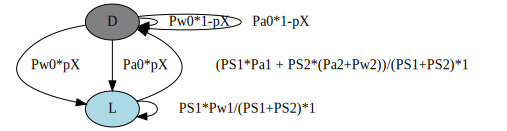

In [33]:
da_graph_light = nx.MultiDiGraph()
da_graph_light.add_nodes_from([("D", {"fillcolor": "grey", "subset":0}), ("L", {"fillcolor": "lightblue", "subset":0})])
edges = [("D", "L", "Pw0", {"p":"pX"}),
         ("D", "D", "Pw0", {"p":"1-pX"}),
         ("D", "L", "Pa0", {"p":"pX"}),
         ("D", "D", "Pa0", {"p":"1-pX"}),
         ("L", "D", "(PS1*Pa1 + PS2*(Pa2+Pw2))/(PS1+PS2)", {"p":1}),
         ("L", "L", "PS1*Pw1/(PS1+PS2)", {"p":1})]
da_graph_light.add_edges_from(edges)
labels = {(edge[0], edge[1], edge[2]):str(edge[2] + "*" + str(edge[3]["p"]) + "   ") for edge in da_graph_light.edges(data = True, keys = True)}
nx.set_edge_attributes(da_graph_light, labels, "label")

D = nx.drawing.nx_agraph.to_agraph(da_graph_light)
D.node_attr.update(style = "filled")
D.layout('dot')

D

One can now calculate the probability to observe a light- or dark-state using the limiting state probabilities from above:
$$
P_D = P_{S0} = \frac{1}{1 + p_X(2-\pi_{a1})}, P_L = P_{S1}+P_{S2} = \frac{p_X(2-\pi_{a1})}{1 + p_X(2-\pi_{a1})}
$$

In [48]:
import sympy as sp

x = sp.Symbol("p_X")
a1 = sp.Symbol("\pi_{a1}")
z = sp.Symbol("z")

P = sp.Matrix([[1-x, x], [1/(2-a1), (1-a1)/(2-a1)]])

A = sp.eye(2) - P*z
print(" also: G(z)=")
sp.apart(A.inv(), z)

 also: G(z)=


Matrix([
[p_X*(\pi_{a1} - 2)**2/((\pi_{a1}*p_X - 2*p_X - 1)*(\pi_{a1}*p_X*z - \pi_{a1}*z + \pi_{a1} - 2*p_X*z + z - 2)) + 1/((z - 1)*(\pi_{a1}*p_X - 2*p_X - 1)), -p_X*(\pi_{a1} - 2)**2/((\pi_{a1}*p_X - 2*p_X - 1)*(\pi_{a1}*p_X*z - \pi_{a1}*z + \pi_{a1} - 2*p_X*z + z - 2)) - p_X*(\pi_{a1} - 2)/((z - 1)*(\pi_{a1}*p_X - 2*p_X - 1))],
[       (\pi_{a1} - 2)/((\pi_{a1}*p_X - 2*p_X - 1)*(\pi_{a1}*p_X*z - \pi_{a1}*z + \pi_{a1} - 2*p_X*z + z - 2)) + 1/((z - 1)*(\pi_{a1}*p_X - 2*p_X - 1)),        -p_X*(\pi_{a1} - 2)/((z - 1)*(\pi_{a1}*p_X - 2*p_X - 1)) - (\pi_{a1} - 2)/((\pi_{a1}*p_X - 2*p_X - 1)*(\pi_{a1}*p_X*z - \pi_{a1}*z + \pi_{a1} - 2*p_X*z + z - 2))]])

Only looking at the actions of the agent also results in a two state MP, with rather trivial transition probabilities:
$$
P_A = P_{S_0}\pi_{a0} + P_{S_1}\pi_{a1} + P_{S_2}\pi_{a2} = \frac{\pi_{a0} + p_X\pi_{a1} + p_X(1-\pi_{a1})\pi_{a2}}{1 + p_X(2-\pi_{a1})}, P_W = 1- P_A
$$

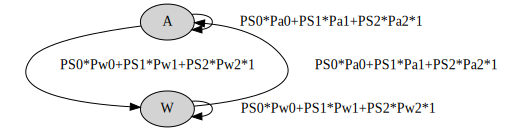

In [31]:
da_graph_action = nx.MultiDiGraph()
da_graph_action.add_nodes_from([("A", {"subset":0}), ("W", {"subset":0})])
edges = [("A", "A", "PS0*Pa0+PS1*Pa1+PS2*Pa2", {"p":1}),
         ("A", "W", "PS0*Pw0+PS1*Pw1+PS2*Pw2", {"p":1}),
         ("W", "A", "PS0*Pa0+PS1*Pa1+PS2*Pa2", {"p":1}),
         ("W", "W", "PS0*Pw0+PS1*Pw1+PS2*Pw2", {"p":1})]
da_graph_action.add_edges_from(edges)
labels = {(edge[0], edge[1], edge[2]):str(edge[2] + "*" + str(edge[3]["p"]) + "   ") for edge in da_graph_action.edges(data = True, keys = True)}
nx.set_edge_attributes(da_graph_action, labels, "label")

D = nx.drawing.nx_agraph.to_agraph(da_graph_action)
D.node_attr.update(style = "filled")
D.layout('dot')

D

One can now also think about combining the two observations, so for example the observer allways gets the information about the current state of the light and the action of the agent that brought it to that state.
This will now result in a MP with four states.

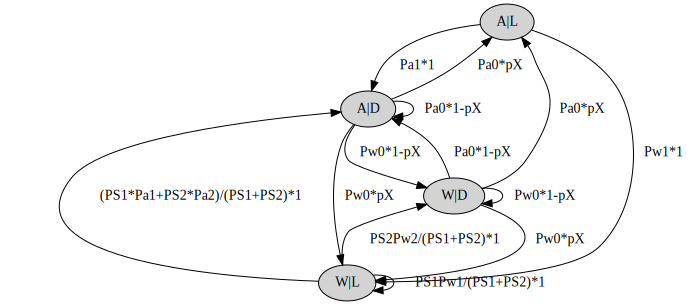

In [37]:
da_graph_combined = nx.MultiDiGraph()
da_graph_combined.add_nodes_from([("A|L", {"subset":0}), ("A|D", {"subset":0}), ("W|L", {"subset":0}), ("W|D", {"subset":0})])
edges = [#("A|L", "A|L", "0", {"p":1}),
         ("A|L", "A|D", "Pa1", {"p":1}),
         ("A|L", "W|L", "Pw1", {"p":1}),
         #("A|L", "W|D", "0", {"p":1}),
         ("A|D", "A|L", "Pa0", {"p":"pX"}),
         ("A|D", "A|D", "Pa0", {"p":"1-pX"}),
         ("A|D", "W|L", "Pw0", {"p":"pX"}),
         ("A|D", "W|D", "Pw0", {"p":"1-pX"}),
         #("W|L", "A|L", "0", {"p":1}),
         ("W|L", "A|D", "(PS1*Pa1+PS2*Pa2)/(PS1+PS2)", {"p":1}),
         ("W|L", "W|L", "PS1Pw1/(PS1+PS2)", {"p":1}),
         ("W|L", "W|D", "PS2Pw2/(PS1+PS2)", {"p":1}),
         ("W|D", "A|L", "Pa0", {"p":"pX"}),
         ("W|D", "A|D", "Pa0", {"p":"1-pX"}),
         ("W|D", "W|L", "Pw0", {"p":"pX"}),
         ("W|D", "W|D", "Pw0", {"p":"1-pX"})]
da_graph_combined.add_edges_from(edges)
labels = {(edge[0], edge[1], edge[2]):str(edge[2] + "*" + str(edge[3]["p"]) + "   ") for edge in da_graph_combined.edges(data = True, keys = True)}
nx.set_edge_attributes(da_graph_combined, labels, "label")

D = nx.drawing.nx_agraph.to_agraph(da_graph_combined)
D.node_attr.update(style = "filled")
D.layout('dot')

D

In [50]:
import sympy as sp

x = sp.Symbol("p_X")
a0 = sp.Symbol("\pi_{a0}")
a1 = sp.Symbol("\pi_{a1}")
a2 = sp.Symbol("\pi_{a2}")
z = sp.Symbol("z")
ps1 = x/(1+x*(2-a1))
ps2 = x*(1-a1)/(1+x*(2-a1))
#A|L, A|D, W|L, W|D
P = sp.Matrix([[0, a1, 1-a1, 0], 
              [a0*x, a0*(1-x), (1-a0)*x, (1-a0)*(1-x)], 
              [0, (x*a1/(1+x*(2-a1)) + a2*x*(1-a1)/(1+x*(2-a1)))/(x/(1+x*(2-a1))+x*(1-a1)/(1+x*(2-a1))), (1-a1)*x/(1+x*(2-a1))/(x/(1+x*(2-a1))+x*(1-a1)/(1+x*(2-a1))), (1-a2)*x*(1-a1)/(1+x*(2-a1))/(x/(1+x*(2-a1))+x*(1-a1)/(1+x*(2-a1)))], 
              [a0*x, a0*(1-x), (1-a0)*x, (1-a0)*(1-x)]])

A = sp.eye(4) - P*z
print("G(z)=")
sp.apart(A.inv(), z)

G(z)=


KeyboardInterrupt: 

The simplified probabilities for each state are then as follows:
$$
P_{A|L} = \frac{p_X P_{a0}}{2}, P_{W|L} = \frac{4p_X(1-P_{a0}) + 3(1-P_{a1})}{8}, 
P_{A|D} = \frac{4(1-p_X)P_{a0} + 3P_{a1} + P_{a2}}{8}, P_{W|D} = \frac{4(1-p_X)(1-P_{a0}) + 1 - P_{a2}}{8}
$$